In [30]:
import sys
sys.path.append('./../../designer/script/')
from gets.get_spectrum import get_spectrum_simple
from film import FilmSimple
from spectrum import SpectrumSimple
from utils.plot_spectrum import plot_spectrum
import numpy as np
import copy
from utils.merit import calculate_merit
import matplotlib.pyplot as plt

# Initialize
wls = np.linspace(500, 1000, 500)
inc_ang = 60.


def plot_film(f: FilmSimple):
    f.add_spec_param(inc_ang, wls)
    spectrum_before_sub = f.get_spec()
    spectrum_before_sub.calculate() # compile cuda kernel func
    # plot_spectrum(spectrum_before_sub)
np.random.seed(1)
f = FilmSimple("SiO2", "TiO2", "SiO2", np.random.random(200) * 30)
plot_film(f)

In [173]:
f_sub1 = copy.deepcopy(f)



def equal_optical_thickness(f: FilmSimple, d_min):
    d = f.get_d()
    i = 1
    count = 0
    while i < d.shape[0] - 1:
        if d[i] < d_min:
            n_arr = f.calculate_n_array(np.array([750]))
            optical_ratio = n_arr[0, i + 1] / n_arr[0, i]
            d[i - 1] += optical_ratio * d[i] + d[i + 1]
            d = np.delete(d, [i, i + 1])
            i -= 1
            count += 1
        i += 1
    f.update_d(d)
    return count

def search_ot_substitution(f: FilmSimple, f_origin: FilmSimple, d_min):
    d = f.get_d()
    i = 1
    count = 0
    ratios = []
    while i < d.shape[0] - 1:
        if d[i] < d_min:
            n_arr = f.calculate_n_array(np.array([750]))
            optical_ratio = n_arr[0, i + 1] / n_arr[0, i]
            m = calculate_merit(f, f_origin)

            for r in np.linspace(0, d_min * 10, 10):
                d_tmp = d.copy()
                # substitute
                d_tmp[i - 1] += r * optical_ratio * d[i] + d[i + 1]
                d_tmp = np.delete(d_tmp, [i, i + 1])

                f.update_d(d_tmp)
                m = calculate_merit(f, f_origin)
                if r == 0. or m < best_m: # first search set as tmp best
                    best_m = m
                    best_d = d_tmp.copy()
                    best_r = r
            d = best_d
            ratios.append(best_r)
            count += 1

            i -= 1
        i += 1
    f.update_d(d)
    return count, ratios

def search_keeplayer_substitution(f: FilmSimple, f_origin: FilmSimple, d_min, search=None):
    search = np.linspace(d_min, d_min * 100, 100) if search is None else search
    d = f.get_d()
    i = 1
    count = 0
    sub_d_s = []
    merit_record = []
    d_record = []
    while i < d.shape[0] - 1:
        if d[i] < d_min:
            n_arr = f.calculate_n_array(np.array([750]))
            optical_ratio = n_arr[0, i + 1] / n_arr[0, i]

            this_merit_record = []
            this_d_record = []
            for r in search:
                d_iminus1_tmp = d[i]

                d[i] = r
                this_d_record.append(r)

                f.update_d(d)
                m = calculate_merit(f, f_origin)
                this_merit_record.append(m)
                # print(m)
                if r == search[0] or m < best_m: # first search set as tmp best
                    best_m = m
                    best_d = d.copy()
                    best_r = r
                
                d[i] = d_iminus1_tmp # restore to search for others
            d = best_d
            sub_d_s.append(best_r)
            count += 1
            merit_record.append(this_merit_record)
            d_record.append(this_d_record)        
        i += 1

    f.update_d(d)
    return count, sub_d_s, merit_record, d_record

d_mins_1 = np.linspace(0, 10, 100)
merits_1 = []
for d_min in d_mins_1:
    count = equal_optical_thickness(f_sub1, d_min)
    merits_1.append(calculate_merit(f, f_sub1))
    # print(merits[-1], "min d:", d_min, 'and', count, "layers deleted")




C:\Users\rfeng6\AppData\Local\Temp\ipykernel_20268\763014779.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i - 1] += optical_ratio * d[i] + d[i + 1]


In [ ]:

d_mins_2 = np.linspace(0, 10, 100)
merits_2 = []
# takes about 10 min to run
for d_min in d_mins_2:
    f_sub2 = copy.deepcopy(f)
    count = search_ot_substitution(f_sub2, f, d_min)
    print(count)
    merits_2.append(calculate_merit(f, f_sub2))

fig, ax = plt.subplots(1, 1)
ax.plot(d_mins_1, merits_1, label='equal OT sub')
ax.plot(d_mins_2, merits_2, label='search OT sub')

ax.set_xlabel('minimum allowed thin layer thickness / nm')
ax.set_ylabel('difference in RMS')
ax.legend()

In [174]:


d_mins_3 = np.linspace(0, 10, 100)
merits_3 = []
m_records = []
d_records = []

# takes about 60 mins to run
for d_min in d_mins_2:
    f_sub3 = copy.deepcopy(f)
    count, ratios, m_records_this_dmin, d_records_this_dmin = search_keeplayer_substitution(f_sub3, f, d_min)
    m_records.append(m_records_this_dmin)
    d_records.append(d_records_this_dmin)
    # print(count)
    merits_3.append(calculate_merit(f, f_sub3))



In [ ]:
# I kind of don't understand why d_min small the merit explodes
# so try more


d_mins_4 = np.linspace(0, 1, 10)
merits_4 = []
m_records = []
d_records = []
for d_min in d_mins_4:
    f_sub4 = copy.deepcopy(f)
    count, sub_ds, m_records_this_dmin, d_records_this_dmin = search_keeplayer_substitution(
        f_sub4,
        f,
        d_min
    )
    m_records.append(m_records_this_dmin)
    d_records.append(d_records_this_dmin)
    # print(sub_ds)
    merits_4.append(calculate_merit(f, f_sub4))



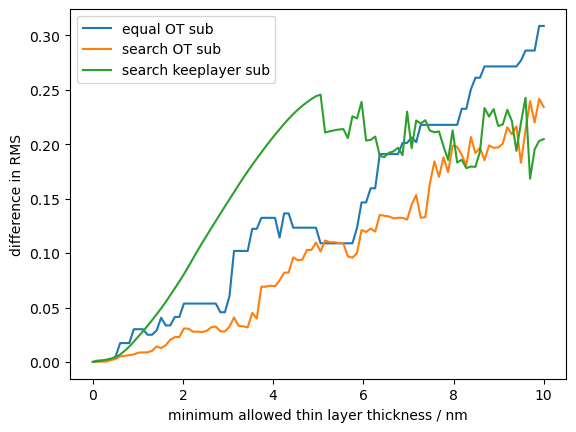

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(d_mins_1, merits_1, label='equal OT sub')
ax.plot(d_mins_2, merits_2, label='search OT sub')
ax.plot(d_mins_3, merits_3, label='search keeplayer sub')

ax.set_xlabel('minimum allowed thin layer thickness / nm')
ax.set_ylabel('difference in RMS')
ax.legend()

TypeError: Invalid shape (10,) for image data

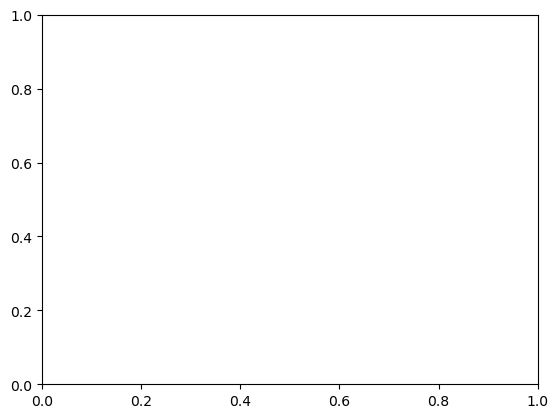

In [ ]:
subed_layer = 0 # layer
d_min_idx = 30 # should > 0

least_d_min_idx = 0
while True:
    try:
        ds = np.array([d_records[i][subed_layer] for i in range(least_d_min_idx, len(d_mins_4))])
        ms = np.array([m_records[i][subed_layer] for i in range(least_d_min_idx, len(d_mins_4))])
    except:
        least_d_min_idx += 1
    else:
        break


fig, ax = plt.subplots(1, 1)
s = ax.imshow(ms, aspect='auto')
ax.invert_yaxis()
ax.set_xlim(0.5, None)
ax.set_xlabel('INDEX of substituted d')
ax.set_ylabel('INDEX of min allowed d')
cbar = fig.colorbar(s)

print(f.get_d())